In [1]:
import os
os.chdir('E:/tp2/data')

In [2]:
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.decomposition import FactorAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from gensim.parsing.preprocessing import remove_stopwords
import nltk

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

In [3]:
#load data
train_docs = pd.read_csv('train_posts.csv', names=['blog', 'class']).reset_index(drop=True)
valid_docs = [pd.read_csv('valid/' + val, names=['blog', 'class']) for val in os.listdir("valid")]


In [4]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    return tokens

In [5]:
# Not sure if doc2vec represents well length of initial string. could add the length column 
train_docs

,blog,class
0,"long time.. i have been busy with work, school...",0
1,what to talk about... well today was totaly bo...,0
2,just some stuff which animal is your sex symbo...,0
3,i gots a job now... yesterday i started workin...,0
4,"movie night! i really do hate fridays, because...",0
...,...,...
512624,whenever i hear my band warm down i love it. t...,1
512625,well since the last entry me and my girl talke...,1
512626,*sigh* well tonight me and my girl decided to ...,1
512627,if anyone is awake and acutally reading this p...,1


In [6]:
#The Doc2Vec model takes 'tagged_documents'
#tag the training data
t1 = time()
tagged_tr = [TaggedDocument(words=nltk.word_tokenize(remove_stopwords(str(_d).lower())), tags=[str(i)]) for i, _d in enumerate(train_docs.blog)]
t2 = time()    
print("Time: {}".format(t2-t1))

Time: 685.0044565200806


In [7]:
valid_doc_tagged = [[] for _ in range(len(valid_docs))]
for i, valid_doc in enumerate(valid_docs):
    print(i)
    valid_doc_tagged[i] = [TaggedDocument(words=nltk.word_tokenize(remove_stopwords(str(_d).lower())), tags=[str(i)]) for i, _d in enumerate(valid_doc.blog)]


0
1
2
3
4
5
6
7
8
9
10


In [8]:
#Instantiate the model
alpha=0.025
#build the vocab on the training data
vec_size = 300
window_size = 15
min_count = 2
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 100

start_epoch=59

dm = 0 #0 = dbow; 1 = dmpv
worker_count = 1 #number of parallel processes
filename='5klects300_pretrainedgoogle_dbow.model'
pretrained_emb='GoogleNews-vectors-negative300'
if os.path.isfile(filename):
    print("Model found, loading...")
    model = Doc2Vec.load(filename)
    t1 = time()
    for epoch in range(start_epoch, train_epoch):
        print('iteration {0}'.format(epoch+1))
        model.train(tagged_tr,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

else:
    print("Model not found, training for", train_epoch, "...")
    t1 = time()
    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    window=window_size, 
                    min_count=min_count, 
                    sample=sampling_threshold,
                    workers=worker_count, 
                    hs=0,
                    dm=dm,
                    negative=negative_size, 
                    pretrained_emb=pretrained_emb)
    t2 = time()    
    #model = Doc2Vec(vector_size=100,  min_count=2,dm =1)
    print("Building vocabulary")
    model.build_vocab(tagged_tr)
    #max training epochs

    #train n epochs and save the model
    print("Model created in {}".format(t2-t1) )
    t1 = time()
    for epoch in range(train_epoch):
        print('iteration {0}'.format(epoch+1))
        model.train(tagged_tr,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha



print("done!")
t2 = time()    
model.save(filename)
print("Model Saved")
print("Time: {}".format(t2-t1))


Model not found, training for 100 ...
Building vocabulary
Model created in 0.0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59


KeyboardInterrupt: 

In [9]:
model.save(filename)

In [10]:
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train_docs['class']

from imblearn.over_sampling import SVMSMOTE, SMOTE, BorderlineSMOTE, RandomOverSampler, KMeansSMOTE

# sm = SVMSMOTE(random_state=42, n_jobs=-1, svm_estimator=SVC(kernel='linear'))
sm = RandomOverSampler(random_state=42)
t1 = time()
X_res, y_res = sm.fit_resample(X_train, y_train)
t2 = time()        
print("Time for Reseampling: {}".format(t2-t1))
np.save('E:/tp2/data/train_posts_smote2_data', X_res)
np.save('E:/tp2/data/train_posts_smote2_targets', y_res)
df1 = pd.DataFrame(X_res)
df2 = pd.DataFrame(y_res, columns=["class"])
df = pd.concat([df1, df2], axis = 1).reset_index(drop=True) # seems like smote put them in order, need to shuffle

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tp2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tp2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tp2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tp2\lib\site-packages\t

Time for Reseampling: 0.8198091983795166


In [11]:
X_train, y_train = df[df1.keys()], df["class"]
scaler = StandardScaler()
x = scaler.fit_transform(X_train)

In [12]:
X_valids = [[] for _ in range(len(valid_docs))]
for n, valid_doc in enumerate(valid_doc_tagged):
    print(n)
    X_valids[n] = np.array([model.infer_vector(valid.words) for valid in valid_doc])


0
1
2
3
4
5
6
7
8
9
10


In [13]:
X_valids = [scaler.transform(val) for i, val in enumerate(X_valids)]
y_valids = [valid['class'] for valid in valid_docs] 

<BarContainer object of 3 artists>

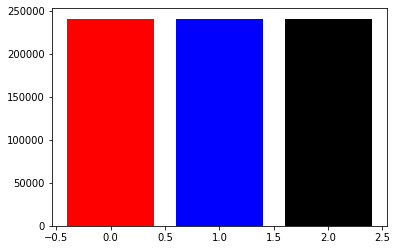

In [14]:
zeros = np.sum([1 if y==0 else 0 for y in y_train])
ones = np.sum([1 if y==1 else 0 for y in y_train])
twos = np.sum([1 if y==2 else 0 for y in y_train])

plt.bar([0, 1, 2], [zeros, ones, twos], color=['r', 'b', 'k'])

In [15]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_train.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

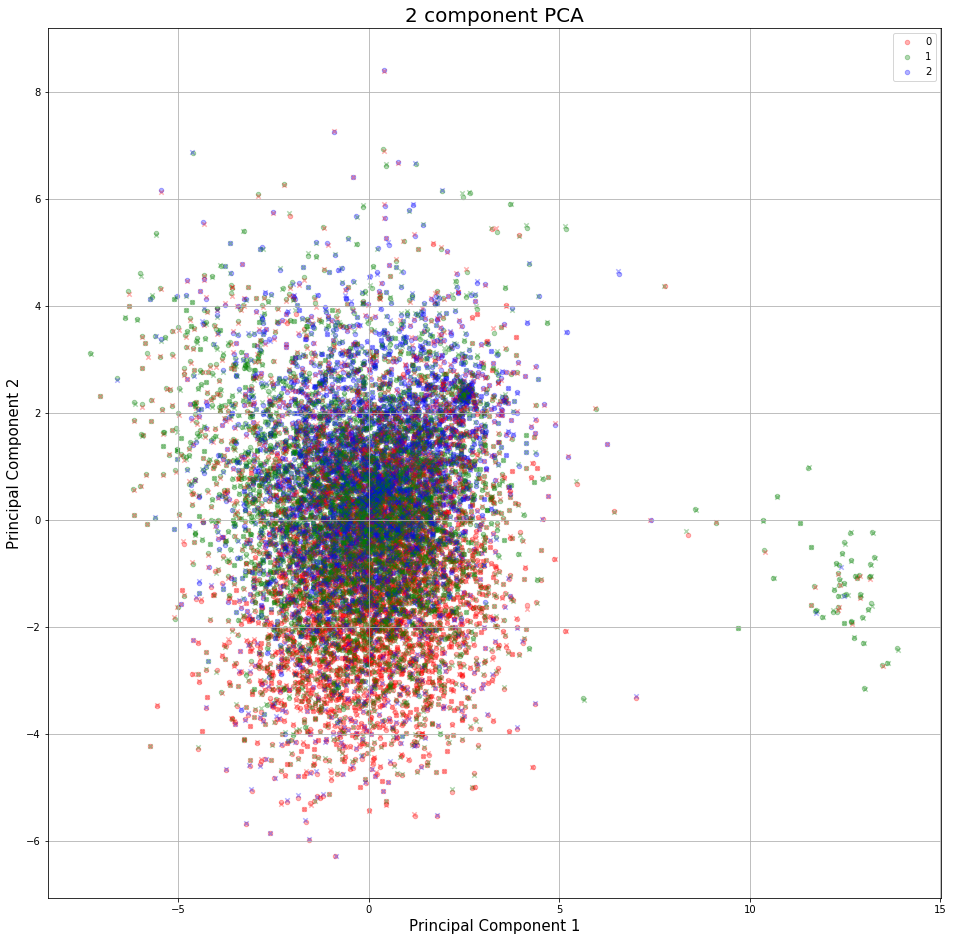

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_pca = pd.concat([principalDf, y_train[:10000]], axis = 1).reset_index(drop=True)

principalComponents_valid = pca.fit_transform(x[:10000])
principalDf_valid = pd.DataFrame(data=principalComponents_valid, columns=['principal component 1', 'principal component 2'])
finalDf_pca_valid = pd.concat([principalDf_valid, y_valids[0][:10000]], axis = 1).reset_index(drop=True)


fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1']
               , finalDf_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )


for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca_valid['class'] == target
    ax.scatter(finalDf_pca_valid.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca_valid.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 20, alpha=0.3, marker='x'
              )

ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_pca, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

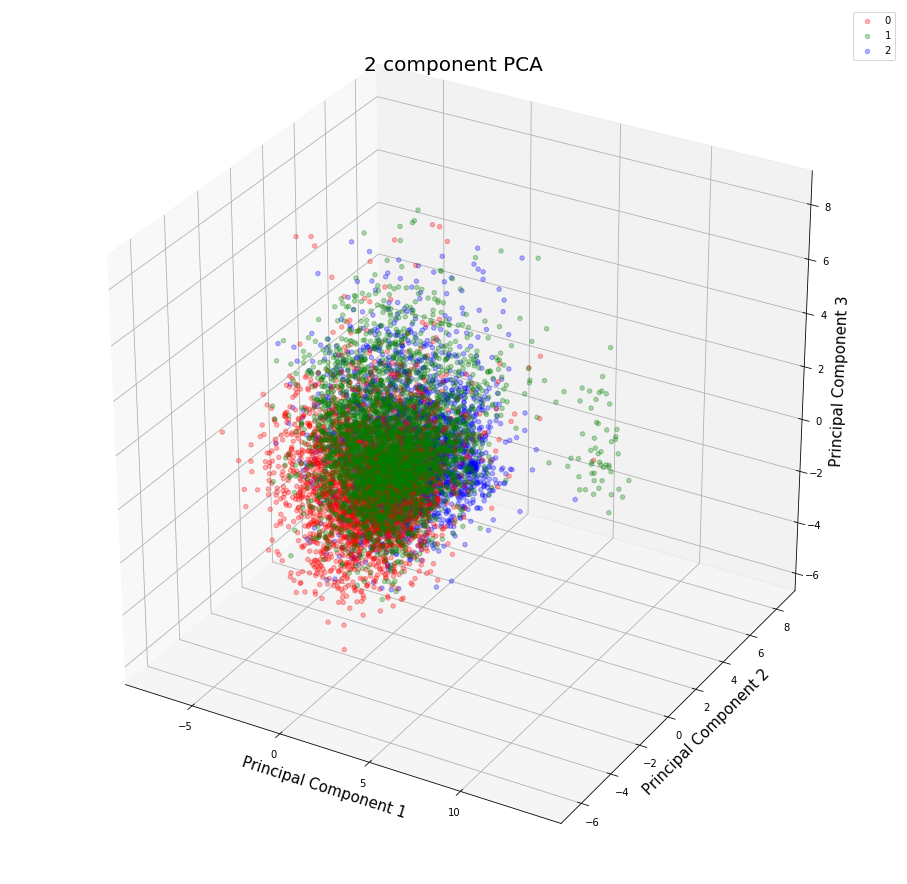

In [17]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2',  'principal component 3'])
finalDf_pca = pd.concat([principalDf, y_train[:10000]], axis = 1).reset_index(drop=True)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

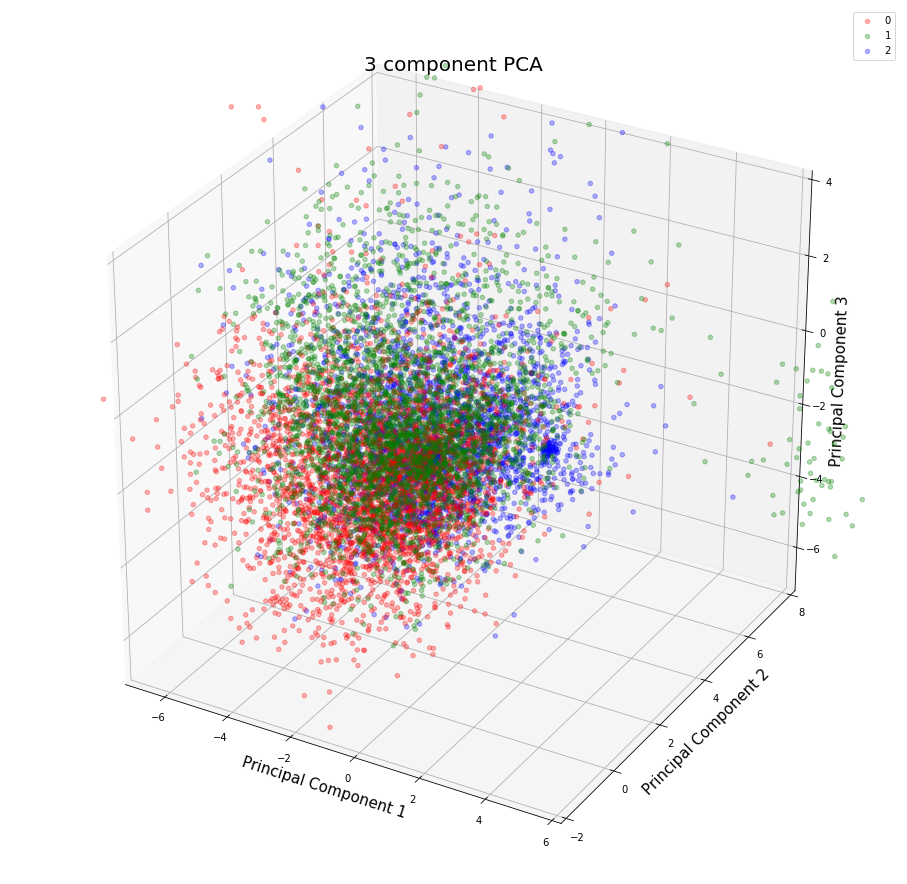

In [18]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
ax.set_xlim([-7, 6])
ax.set_ylim([-2, 8])
ax.set_zlim([-7, 4])

ax.legend(targets)
ax.grid()

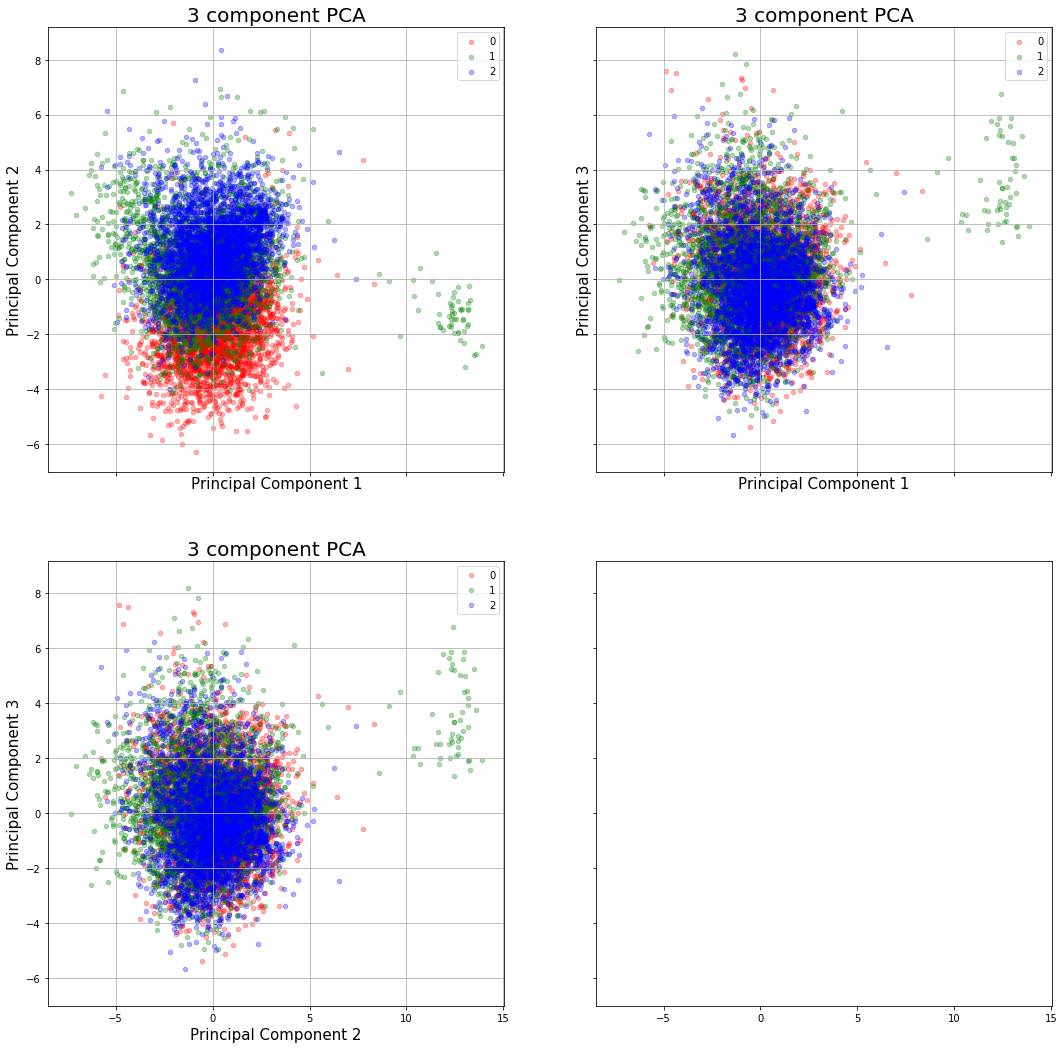

In [19]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(18, 18))
axs[0][0].set_xlabel('Principal Component 1', fontsize = 15)
axs[0][0].set_ylabel('Principal Component 2', fontsize = 15)
axs[0][0].set_title('3 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[0][0].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 20, alpha=0.3
              )
axs[0][0].legend(targets)
axs[0][0].grid()

axs[0][1].set_xlabel('Principal Component 1', fontsize = 15)
axs[0][1].set_ylabel('Principal Component 3', fontsize = 15)
axs[0][1].set_title('3 component PCA', fontsize = 20)
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[0][1].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
axs[0][1].legend(targets)
axs[0][1].grid()

axs[1][0].set_xlabel('Principal Component 2', fontsize = 15)
axs[1][0].set_ylabel('Principal Component 3', fontsize = 15)
axs[1][0].set_title('3 component PCA', fontsize = 20)
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[1][0].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
axs[1][0].legend(targets)
axs[1][0].grid()
plt.show()

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fLDA = LinearDiscriminantAnalysis(n_components=2)
y=y_train
principalComponents = fLDA.fit_transform(x, y)
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal component 1', 'Principal component 2'])
finalDf_fLDA = pd.concat([principalDf, y], axis = 1)

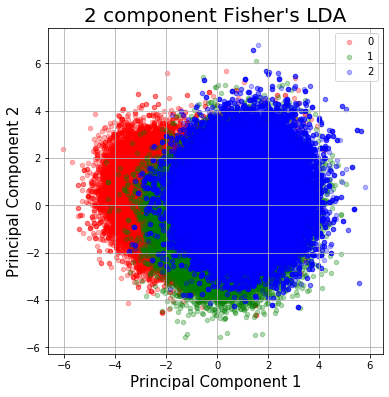

In [21]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component Fisher\'s LDA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_fLDA['class'] == target
    ax.scatter(finalDf_fLDA.loc[indicesToKeep, 'Principal component 1']
               , finalDf_fLDA.loc[indicesToKeep, 'Principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='Principal component 1', y='Principal component 2', hue='class', data=finalDf_fLDA, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='Principal component 1', y='Principal component 2', z='Principal component 3', hue='class', 
                     data=finalDf_fLDA, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fa = FactorAnalysis(n_components=2)
principalComponents = fa.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_fa = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_fa['class'] == target
    ax.scatter(finalDf_fa.loc[indicesToKeep, 'principal component 1']
               finalDf_fa.loc[indicesToKeep, 'principal component 2']
               c = color
               s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
tsne = TSNE(n_components=2, learning_rate=10000)
principalComponents = tsne.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_TSNE = pd.concat([principalDf, y_train], axis = 1)

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE['class'] == target
    ax.scatter(finalDf_TSNE.loc[indicesToKeep, 'principal component 1']
               , finalDf_TSNE.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE['class'] == target
    ax.scatter(finalDf_TSNE.loc[indicesToKeep, 'principal component 1']
               , finalDf_TSNE.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
plt.xlim([-75, 75])
plt.ylim([-75, 75])
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_TSNE, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_TSNE, s=50, palette=['red', 'green', 'blue'], alpha=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])


In [ ]:
tsne = TSNE(n_components=3, learning_rate=10000)
principalComponents = tsne.fit_transform(x[:1000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2', 'principal component 3'])
finalDf_TSNE3d = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE3d['class'] == target
    ax.scatter(finalDf_TSNE3d.loc[indicesToKeep, 'principal component 1'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 2'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, 
               alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE3d['class'] == target
    ax.scatter(finalDf_TSNE3d.loc[indicesToKeep, 'principal component 1'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 2'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, 
               alpha=0.3
              )
ax.set_xlim([-400, 200])
ax.set_ylim([-200, 300])
ax.set_zlim([-400, 200])
ax.legend(targets)
ax.grid()

In [ ]:
from sklearn.naive_bayes import GaussianNB
mnb = GaussianNB()
y_pred  = cross_val_predict(mnb, x, y_train, cv=10, verbose=1)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.naive_bayes import GaussianNB
mnb = GaussianNB()
mnb.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = mnb.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

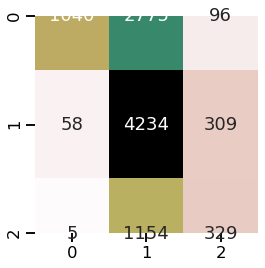

              precision    recall  f1-score   support

           0       0.94      0.27      0.41      3911
           1       0.52      0.92      0.66      4601
           2       0.45      0.22      0.30      1488

    accuracy                           0.56     10000
   macro avg       0.64      0.47      0.46     10000
weighted avg       0.67      0.56      0.51     10000



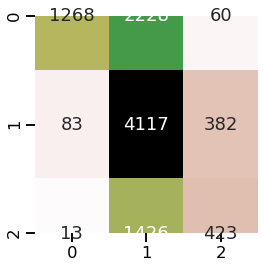

              precision    recall  f1-score   support

           0       0.93      0.36      0.52      3556
           1       0.53      0.90      0.67      4582
           2       0.49      0.23      0.31      1862

    accuracy                           0.58     10000
   macro avg       0.65      0.49      0.50     10000
weighted avg       0.66      0.58      0.55     10000



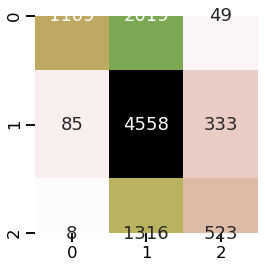

              precision    recall  f1-score   support

           0       0.92      0.35      0.51      3177
           1       0.58      0.92      0.71      4976
           2       0.58      0.28      0.38      1847

    accuracy                           0.62     10000
   macro avg       0.69      0.52      0.53     10000
weighted avg       0.69      0.62      0.58     10000



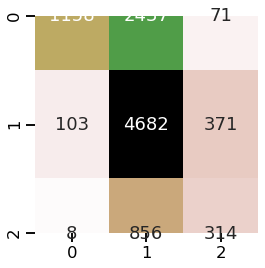

              precision    recall  f1-score   support

           0       0.91      0.32      0.47      3666
           1       0.59      0.91      0.71      5156
           2       0.42      0.27      0.32      1178

    accuracy                           0.62     10000
   macro avg       0.64      0.50      0.50     10000
weighted avg       0.69      0.62      0.58     10000



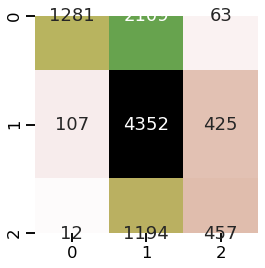

              precision    recall  f1-score   support

           0       0.92      0.37      0.53      3453
           1       0.57      0.89      0.69      4884
           2       0.48      0.27      0.35      1663

    accuracy                           0.61     10000
   macro avg       0.66      0.51      0.52     10000
weighted avg       0.67      0.61      0.58     10000



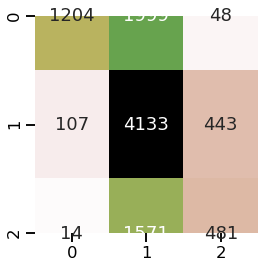

              precision    recall  f1-score   support

           0       0.91      0.37      0.53      3251
           1       0.54      0.88      0.67      4683
           2       0.49      0.23      0.32      2066

    accuracy                           0.58     10000
   macro avg       0.65      0.50      0.50     10000
weighted avg       0.65      0.58      0.55     10000



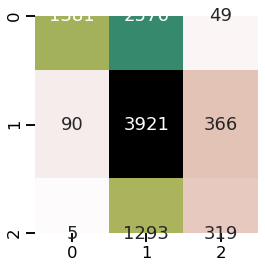

              precision    recall  f1-score   support

           0       0.94      0.34      0.50      4006
           1       0.50      0.90      0.64      4377
           2       0.43      0.20      0.27      1617

    accuracy                           0.56     10000
   macro avg       0.62      0.48      0.47     10000
weighted avg       0.67      0.56      0.53     10000



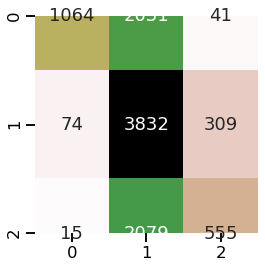

              precision    recall  f1-score   support

           0       0.92      0.34      0.50      3136
           1       0.48      0.91      0.63      4215
           2       0.61      0.21      0.31      2649

    accuracy                           0.55     10000
   macro avg       0.67      0.49      0.48     10000
weighted avg       0.66      0.55      0.50     10000



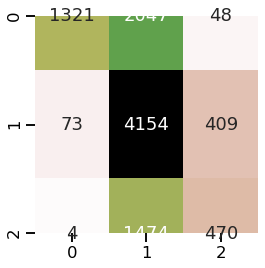

              precision    recall  f1-score   support

           0       0.94      0.39      0.55      3416
           1       0.54      0.90      0.67      4636
           2       0.51      0.24      0.33      1948

    accuracy                           0.59     10000
   macro avg       0.66      0.51      0.52     10000
weighted avg       0.67      0.59      0.56     10000



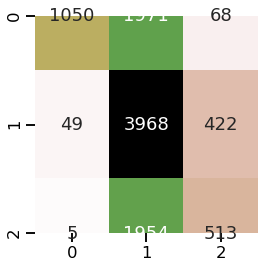

              precision    recall  f1-score   support

           0       0.95      0.34      0.50      3089
           1       0.50      0.89      0.64      4439
           2       0.51      0.21      0.30      2472

    accuracy                           0.55     10000
   macro avg       0.66      0.48      0.48     10000
weighted avg       0.64      0.55      0.51     10000



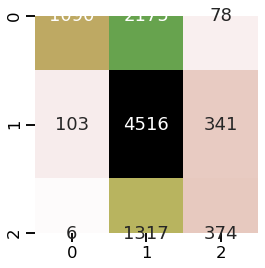

              precision    recall  f1-score   support

           0       0.91      0.33      0.48      3343
           1       0.56      0.91      0.70      4960
           2       0.47      0.22      0.30      1697

    accuracy                           0.60     10000
   macro avg       0.65      0.49      0.49     10000
weighted avg       0.66      0.60      0.56     10000



In [22]:
#y_pred  = cross_val_predict(LinearDiscriminantAnalysis(), x, y_train, cv=3)
#heatconmat(y_train, y_pred)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = fLDA.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

In [ ]:
lrc = LogisticRegression(C=5, multi_class='multinomial', class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40, verbose=1)
y_pred  = cross_val_predict(lrc, x, y_train, cv=3, verbose=1)
heatconmat(y_train, y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.3min finished


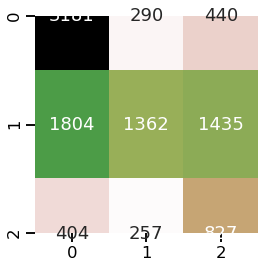

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      3911
           1       0.71      0.30      0.42      4601
           2       0.31      0.56      0.39      1488

    accuracy                           0.54     10000
   macro avg       0.54      0.56      0.50     10000
weighted avg       0.60      0.54      0.52     10000



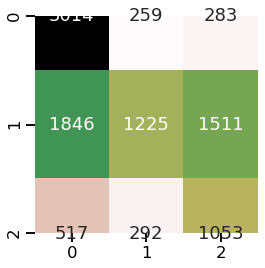

              precision    recall  f1-score   support

           0       0.56      0.85      0.67      3556
           1       0.69      0.27      0.39      4582
           2       0.37      0.57      0.45      1862

    accuracy                           0.53     10000
   macro avg       0.54      0.56      0.50     10000
weighted avg       0.58      0.53      0.50     10000



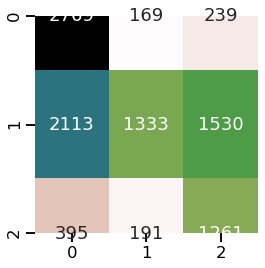

              precision    recall  f1-score   support

           0       0.52      0.87      0.66      3177
           1       0.79      0.27      0.40      4976
           2       0.42      0.68      0.52      1847

    accuracy                           0.54     10000
   macro avg       0.58      0.61      0.52     10000
weighted avg       0.64      0.54      0.50     10000



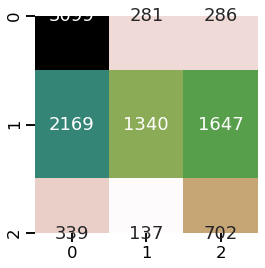

              precision    recall  f1-score   support

           0       0.55      0.85      0.67      3666
           1       0.76      0.26      0.39      5156
           2       0.27      0.60      0.37      1178

    accuracy                           0.51     10000
   macro avg       0.53      0.57      0.47     10000
weighted avg       0.63      0.51      0.49     10000



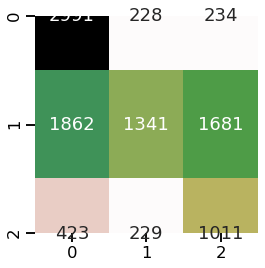

              precision    recall  f1-score   support

           0       0.57      0.87      0.69      3453
           1       0.75      0.27      0.40      4884
           2       0.35      0.61      0.44      1663

    accuracy                           0.53     10000
   macro avg       0.55      0.58      0.51     10000
weighted avg       0.62      0.53      0.51     10000



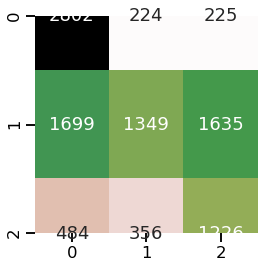

              precision    recall  f1-score   support

           0       0.56      0.86      0.68      3251
           1       0.70      0.29      0.41      4683
           2       0.40      0.59      0.48      2066

    accuracy                           0.54     10000
   macro avg       0.55      0.58      0.52     10000
weighted avg       0.59      0.54      0.51     10000



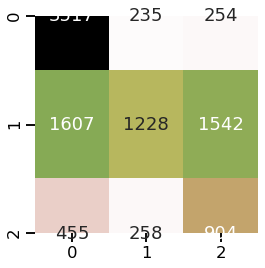

              precision    recall  f1-score   support

           0       0.63      0.88      0.73      4006
           1       0.71      0.28      0.40      4377
           2       0.33      0.56      0.42      1617

    accuracy                           0.56     10000
   macro avg       0.56      0.57      0.52     10000
weighted avg       0.62      0.56      0.54     10000



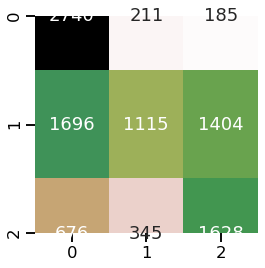

              precision    recall  f1-score   support

           0       0.54      0.87      0.66      3136
           1       0.67      0.26      0.38      4215
           2       0.51      0.61      0.56      2649

    accuracy                           0.55     10000
   macro avg       0.57      0.58      0.53     10000
weighted avg       0.58      0.55      0.52     10000



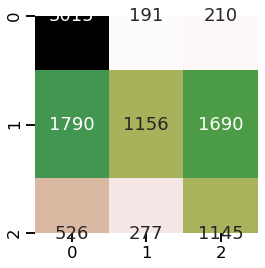

              precision    recall  f1-score   support

           0       0.57      0.88      0.69      3416
           1       0.71      0.25      0.37      4636
           2       0.38      0.59      0.46      1948

    accuracy                           0.53     10000
   macro avg       0.55      0.57      0.51     10000
weighted avg       0.60      0.53      0.50     10000



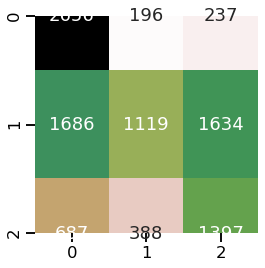

              precision    recall  f1-score   support

           0       0.53      0.86      0.65      3089
           1       0.66      0.25      0.36      4439
           2       0.43      0.57      0.49      2472

    accuracy                           0.52     10000
   macro avg       0.54      0.56      0.50     10000
weighted avg       0.56      0.52      0.48     10000



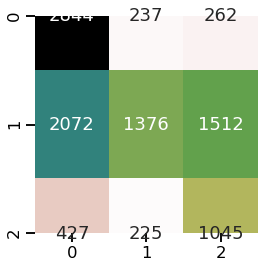

              precision    recall  f1-score   support

           0       0.53      0.85      0.65      3343
           1       0.75      0.28      0.40      4960
           2       0.37      0.62      0.46      1697

    accuracy                           0.53     10000
   macro avg       0.55      0.58      0.51     10000
weighted avg       0.61      0.53      0.50     10000



In [23]:
lrc = LogisticRegression(C=5, multi_class='multinomial', class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40, verbose=1)
lrc.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = lrc.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0, verbose=1, n_jobs=-1)
y_pred  = cross_val_predict(rfc, x, y_train, cv=3, verbose=1)
heatconmat(y_train, y_pred)

In [ ]:
rfc.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = rfc.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

In [ ]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_train.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
gm = BayesianGaussianMixture(3)
gm.fit(X_train, y_train)
y_pred = gm.predict(X_train)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#svc=SVC(probability=True, kernel='linear')
clf = RandomForestClassifier(n_estimators=100, random_state=0)
ada = AdaBoostClassifier(base_estimator=clf, algorithm='SAMME.R')
#y_pred = cross_val_predict(ada, x, y_train, cv=10)
#heatconmat(y_train, y_pred)

In [ ]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_train)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
bag = BaggingClassifier(base_estimator=clf)
y_pred = cross_val_predict(bag, x, y_train, cv=10)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(3)
bgm.fit(x, y_train)  
y_pred = cross_val_predict(bgm, x, y_train, cv=10)
heatconmat(y_train, y_pred)
y_preds = [bgm.predict()]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
analyzer, min_df, ... = get_args()    
# to be implemented # a number of options can control a vectorizer, I reckon you investigate them  
vectorizer = TfidfVectorizer(analyzer=analyzer, min_df=min_df,                                                    
                             max_df=max_df, max_features=max_features,                                                    
                             ngram_range=(ngram_inf,ngram_sup),                                                    
                             stop_words='english') 
df = pd.read_csv(sys.stdin, names=['blog', 'class'])
X_train = vectorizer.fit_transform(df[blog])                                      
# isn’t life beautiful ? # several meta-parameters can influence the performance of Logit (investigate) 
clf = LogisticRegression(C=5,class_weight='balanced', solver='newton-cg',                                              
                         multi_class='multinomial', n_jobs=-1, random_state=40, verbose=1) 
clf.fit(X_train, df[classe])              

In [ ]:
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='linear')
#y_pred = cross_val_predict(svc, x, y_train, cv=3, verbose=1)
#heatconmat(y_train, y_pred)